# Mental Health Attitudes and their impacts on Tech Organizations 
***By: Divya Joseph***

**Table of Contents**  
   1. Import Data
   2. Background
   3. Cleaning Data
   4. Exploratory Data Analysis 
   5. Results

### 1. Background

For this data science project, I wanted to interpret and work on a data set that I was very curious about. As background, I’m very interested in health care, but have an engineering background and am planning on working in biotech, or a related field in the future. As such, when I came across a data set about attitudes on mental health in tech workplaces, I was intrigued.  From what I have experienced so far as a young professional, my knowledge about mental health in tech workplaces is that currently it is a fairly stigmatized topic. From what I know, mental health is not often talked about and is not something employers encourage employees to discuss, though it is important, in my opinion. 

I thought it would be interesting to analyze and interpret data about this topic and to see if I could answer some of the already present questions I have in my mind about working in tech and to understand what individuals in the current working sector have experienced. Moreover, this information and interpretation would be vital to most tech organizations that are looking out for the best for their employees, as healthy discussion of health is important in employee satisfaction and retention. For context, I would define workplace attitudes as the company culture surrounding certain topics, in this case, mental health, and underlying policies and procedures put into place around these topics. 

As such, some of the questions I would like to address for this data science project would be the following:

-	To understand how the willingness of the employee to discuss mental health with their employers may be related to the programs that the workplace offers and if this varies by gender in the various countries analyzed. 
-	To see if there is an underlying stigma in the workplace against mental health – in the attitudes of the culture of attitudes & if this impacts the presence of mental illness and the relative inability of employees to speak up to employers. 


**Data**

The data itself comes from an organization called the OSMI, or Open Sourcing Mental Illness, who focus on bringing awareness to mental health in the areas of tech and work. The information for the data set was acquired through surveys which individuals from all over the globe were able to take regarding different characteristics of their working environment, and general attitudes about mental wellness. Anyone with access to the link is able to take the survey.

The way that I found this data set was through Kaggle, although the data is available in its raw form on the OSMI website. OSMI releases the survey every 1-2 years where the raw data is available to the public on the website. 

On Kaggle and what I observed on the OSMI website, the data has been used in various ways. On the Kaggle website, the data has been used to come up with some higher-level suggestions for companies and individuals on the topic of mental wellness in tech companies [1]. On Kaggle, there have been multiple projects using this data set where most of the discussion surrounded the topic of the geographical differences in attitudes on mental health, as well as the analysis of some of the strongest predictors of mental illness or certain attitudes [2,3]. Another interesting analysis involved the prediction of whether an individual should seek treatment for their mental illness based on the survey results [4].  From the extent of the analyses I have seen, I have not seen a similar analysis to what I would like to perform, but I believe it would be useful so that as a future employee, and as a future leader, I will be informed of the issues and of any stigma surrounding this topic. 

**Merged Data**

I also wanted to see if there was any correlation in the country that the data was extracted, the attitudes about mental health, and the happiness index of that specific country. For this purpose, I obtained a data set from 2015 describing the happiness index of each country and merged this information into the survey data [5]. This data set was obtained though Kaggle but the origin is from the Gallup World Poll that calculates a countries happiness score through six factors: economic production, social support, life expectancy, freedom, absence of corruption, and generosity. 

### 2. Importing Datasets

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pickle
from scipy import stats
from datetime import datetime
from dateutil.parser import parse
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import l1_min_c
from sklearn.metrics import roc_curve, auc
sns.set_context('talk')
sns.set_style('darkgrid')
sns.set_palette('colorblind')

#### Survey Data

First, we will import the survey data and rename the columns to make the later analysis less complicated. 

In [11]:
data = pd.read_csv('https://docs.google.com/spreadsheets/d/1cr65P3ciL2tD4W4KOCTz4Ik67iD52S_DKHXypqgta2o/export?format=csv')

reassign the names of the columns to change lengthy survey question titles to short variable names to simplify later analysis

In [12]:
data.columns = ['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'comments' ]
data.head(1)

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,8/27/2014 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN


In [13]:
data = data.reset_index(drop=True); 

### Variables: 

+ **Timestamp**
+ **Age**
+ **Gender**
+ **Country**
+ **state**: If you live in the United States, which state or territory do you live in?
+ **self_employed**: Are you self-employed?
+ **family_history**: Do you have a family history of mental illness?
+ **treatment**: Have you sought treatment for a mental health condition?
+ **work_interfere**: If you have a mental health condition, do you feel that it interferes with your work?
+ **no_employees**: How many employees does your company or organization have?
+ **remote_work**: Do you work remotely (outside of an office) at least 50% of the time?
+ **tech_company**: Is your employer primarily a tech company/organization?
+ **benefits**: Does your employer provide mental health benefits?
+ **care_options**: Do you know the options for mental health care your employer provides?
+ **wellness_program**: Has your employer ever discussed mental health as part of an employee wellness program?
+ **seek_help**: Does your employer provide resources to learn more about mental health issues and how to seek help?
+ **anonymity**: Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?
+ **leave**: How easy is it for you to take medical leave for a mental health condition?
+ **mental_health_consequence**: Do you think that discussing a mental health issue with your employer would have negative consequences?
+ **phys_health_consequence**: Do you think that discussing a physical health issue with your employer would have negative consequences?
+ **coworkers:** Would you be willing to discuss a mental health issue with your coworkers?
+ **supervisor:** Would you be willing to discuss a mental health issue with your direct supervisor(s)?
+ **mental_health_interview:** Would you bring up a mental health issue with a potential employer in an interview?
+ **phys_health_interview:** Would you bring up a physical health issue with a potential employer in an interview?
+ **mental_vs_physical:** Do you feel that your employer takes mental health as seriously as physical health?
+ **obs_consequence:** Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?
+ **comments:** Any additional notes or comments

#### Happiness Data

I will now import the happiness score data and will focus on the happiness score and the health (life expectancy) because they will be the columns that are the most releveant to my analysis since I am not focusing on how the happiness score was calculated. 

In [14]:
data_happiness = pd.read_csv('https://docs.google.com/spreadsheets/d/1VW0Br5o_3Q0UcM6RMlS1CL-HGPCr-FYsmys2-HDFUi8/export?format=csv')
dhcolumns = ["Country","Happiness Score","Health (Life Expectancy)"]
data_happiness = data_happiness[dhcolumns]
data_happiness.head()

,Country,Happiness Score,Health (Life Expectancy)
0,Switzerland,7.587,0.94143
1,Iceland,7.561,0.94784
2,Denmark,7.527,0.87464
3,Norway,7.522,0.88521
4,Canada,7.427,0.90563


#### Merging the Datasets

Now, to merge the datasets. I will merge the happiness data to the survey data based on the country column on the survey dataset.

In [15]:
mergedata = data.merge(data_happiness, left_on=["Country"], right_on=["Country"], suffixes=(False, False))
mergedata.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments,Happiness Score,Health (Life Expectancy)
0,8/27/2014 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,No,Some of them,Yes,No,Maybe,Yes,No,NaN,7.119,0.86179
1,8/27/2014 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,No,No,No,No,No,Don't know,No,NaN,7.119,0.86179
2,8/27/2014 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN,7.119,0.86179
3,8/27/2014 11:31:22,33,Male,United States,TN,NaN,Yes,No,Sometimes,6-25,...,No,Yes,Yes,No,Maybe,Don't know,No,NaN,7.119,0.86179
4,8/27/2014 11:31:50,35,Female,United States,MI,NaN,Yes,Yes,Sometimes,1-5,...,Maybe,Some of them,No,No,No,Don't know,No,NaN,7.119,0.86179


### Summarizing the data to understand what needs to be cleaned 

In [16]:
data.describe(include=['O'])

,Timestamp,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
count,1260,1260,1260,744,1242,1260,1260,996,1260,1260,...,1260,1260,1260,1260,1260,1260,1260,1260,1260,164
unique,1249,49,48,45,2,2,2,4,6,2,...,5,3,3,3,3,3,3,3,2,160
top,8/27/2014 16:21:55,Male,United States,CA,No,No,Yes,Sometimes,6-25,No,...,Don't know,No,No,Some of them,Yes,No,Maybe,Don't know,No,* Small family business - YMMV.
freq,2,616,751,138,1096,768,637,466,290,884,...,564,490,926,775,516,1009,558,576,1075,5


In [17]:
#date_string = data.Timestamp;
#date_object = datetime.strptime(date_string, '%d/%m/%Y %I:%M:%p')
#print(date_object)

#df['col'] = pd.to_datetime(df['Timestamp'])

In [18]:
rows = len(data.index)
print ('Number of rows of rows in the table: ', rows)

Number of rows of rows in the table:  1260


### 3. Cleaning the Data

First, we will see what types of variables are available with the data set. 

In [19]:
data.dtypes

Timestamp                    object
Age                           int64
Gender                       object
Country                      object
state                        object
self_employed                object
family_history               object
treatment                    object
work_interfere               object
no_employees                 object
remote_work                  object
tech_company                 object
benefits                     object
care_options                 object
wellness_program             object
seek_help                    object
anonymity                    object
leave                        object
mental_health_consequence    object
phys_health_consequence      object
coworkers                    object
supervisor                   object
mental_health_interview      object
phys_health_interview        object
mental_vs_physical           object
obs_consequence              object
comments                     object
dtype: object

Variables to convert to be used in modeling: Gender, Country, State, ...

Now, to see what if any variables are missing.

Timestamp                       0
Age                             0
Gender                          0
Country                         0
state                         516
self_employed                  18
family_history                  0
treatment                       0
work_interfere                264
no_employees                    0
remote_work                     0
tech_company                    0
benefits                        0
care_options                    0
wellness_program                0
seek_help                       0
anonymity                       0
leave                           0
mental_health_consequence       0
phys_health_consequence         0
coworkers                       0
supervisor                      0
mental_health_interview         0
phys_health_interview           0
mental_vs_physical              0
obs_consequence                 0
comments                     1096
Happiness Score                 0
Health (Life Expectancy)        0
dtype: int64


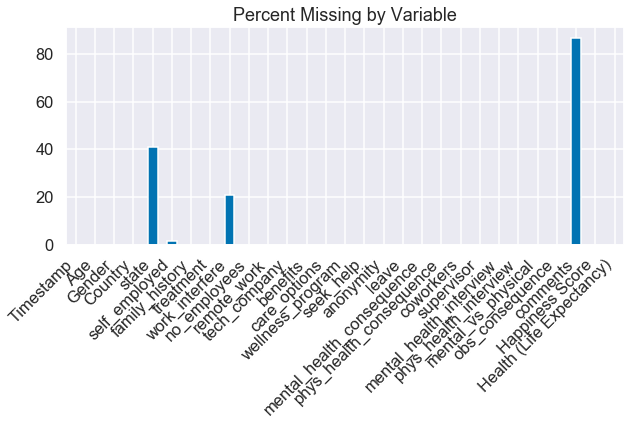

In [20]:
f, ax = plt.subplots(figsize=(10,4))
((mergedata.isnull().sum()/len(mergedata)) * 100).plot(kind='bar')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Percent Missing by Variable')
print((mergedata.isnull().sum()));

It can be noted that the variables with missing variables are: state, self employed, work interfere, and comments. There is missing state data because not all of the individuals who took the survey live in the U.S. I will leave this variable in the dataset for now, so I can later analyze whether there are differences based on state in the U.S. 

Moreover, the reason why there since there is so much data missing in comments, and that information is not necessary for my data analysis, we can get rid of that variable. 

We will leave the rows with missing variables in the dataset for now and get rid of them if they are not needed in interpretation. 

First we will get rid of the comments column:

In [21]:
data.drop('comments', axis=1, inplace = True)

In [22]:
data.head(1)

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,8/27/2014 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No


### 3a.  Cleaning the gender data

When taking a look at the dataset, ,it can be observed that there are multiple versions of each gender. So, when cleaning, I will first clean the gender dataset and see what needs to be done. First, I will see how many unique versions of the Gender variable there are and then clean this data. 

In [23]:
data['Gender'] = data['Gender'].str.lower()

In [24]:
data.Gender.value_counts()
data.Gender.nunique()

43

Needs to be cleaned -- there are various different versions of each gender and other versions that make the data set complicated. 
Male,male,M,m,Make,Man,Mail,msle,maile,Male-ish,Mal,Cis Male, Female (trans), Malr, cis male, Male (CIS), Cis Man
Female,female,F,f,Woman, Female (cis), cis-female/femme
Nah, A little about you, Genderqueer, non-binary, p, queer

In [25]:
gender_df = data["Gender"]
type(gender_df)
terms_to_remove = ["trans", "cis", "queer", "-", "^", "_", ",", "(", ")", "/", "?"]
for i, gender_str in enumerate(gender_df):
    # convert to lowercase
    gender_lowercase_str = gender_str.lower()
    for term in terms_to_remove:
      gender_lowercase_str = gender_lowercase_str.replace(term, "")
    if gender_lowercase_str.startswith("f") or gender_lowercase_str.startswith("she") or "woman" in gender_lowercase_str:
      gender_lowercase_str = "female"
    elif gender_lowercase_str.startswith("m") or "male" in gender_lowercase_str:
      gender_lowercase_str = "male"
    else:
      gender_lowercase_str = "non-binary"

    gender_df[i] = gender_lowercase_str

/miniconda3/envs/em212/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [26]:
data.Gender.value_counts()

male          995
female        252
non-binary     13
Name: Gender, dtype: int64

Since there are not enough non-binary individuals to analyze any significant correlations and since it is not the focus of this project, we will drop this variable. 

In [27]:
data = data[data.Gender != 'non-binary'];

#### Make the gender variable boolean

In [28]:
data = pd.concat([data, pd.get_dummies(data.Gender, drop_first=False)], axis=1)

In [29]:
data.head(3)

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,female,male
0,8/27/2014 11:29:31,37,female,United States,IL,NaN,No,Yes,Often,6-25,...,No,No,Some of them,Yes,No,Maybe,Yes,No,1,0
1,8/27/2014 11:29:37,44,male,United States,IN,NaN,No,No,Rarely,More than 1000,...,Maybe,No,No,No,No,No,Don't know,No,0,1
2,8/27/2014 11:29:44,32,male,Canada,NaN,NaN,No,No,Rarely,6-25,...,No,No,Yes,Yes,Yes,Yes,No,No,0,1


In [30]:
data.Gender.value_counts()

male      995
female    252
Name: Gender, dtype: int64

### 3b. Cleaning the country data

In terms of how many different countries are represented in the survey, the counts can be seen below: 

In [31]:
data.Country.value_counts()

United States             747
United Kingdom            180
Canada                     71
Germany                    44
Ireland                    27
Netherlands                27
Australia                  22
France                     13
India                      10
New Zealand                 8
Poland                      7
Switzerland                 7
Sweden                      7
Italy                       7
Brazil                      6
South Africa                6
Belgium                     6
Israel                      5
Bulgaria                    4
Singapore                   4
Russia                      3
Finland                     3
Austria                     3
Mexico                      3
Greece                      2
Colombia                    2
Portugal                    2
Croatia                     2
Denmark                     2
Japan                       1
Romania                     1
Thailand                    1
Slovenia                    1
Georgia   

The continents that are represented are -  
**North America ; Europe ; Australia ; Asia ; South America**  
However, the majority of the resposes are concentrated in North America and Europe, and the other countries would not provide a thorough and well-informed interpretation. Thus, we can eliminate the data from the survey responses from the other countires.

### 3c. Cleaning the Age Data

In [32]:
data.describe()

,Age,female,male
count,1247.000000,1247.000000,1247.000000
mean,30.846832,0.202085,0.797915
std,51.057106,0.401716,0.401716
min,-1726.000000,0.000000,0.000000
25%,27.000000,0.000000,1.000000
50%,31.000000,0.000000,1.000000
75%,36.000000,0.000000,1.000000
max,329.000000,1.000000,1.000000


Seeing that the distribtion is skewed do to the minimum and maximum ages, we can normalize these by eliminating ages that are not realistic for the working population. Since it can be assumed that individuals over 110 likely do not work as well as those under the age of 12, we can eliminate data that skews the averages. So we insert the average of the data (with the outliers taken out) to be the ages of those outliers: 

In [33]:
data.loc[(data['Age'] > 110), 'Age'] = 32
data.loc[(data['Age'] < 12), 'Age'] = 32

In [34]:
data.describe()

,Age,female,male
count,1247.000000,1247.000000,1247.000000
mean,32.105854,0.202085,0.797915
std,7.282867,0.401716,0.401716
min,18.000000,0.000000,0.000000
25%,27.000000,0.000000,1.000000
50%,31.000000,0.000000,1.000000
75%,36.000000,0.000000,1.000000
max,72.000000,1.000000,1.000000


### 4. Data Interpretation and Visualizations

I will now do some basic data visualization to see what some of the survey results are. There is not much new interpretation to do about this data, so I will look at the basic results and also see if there are any correlations, which is the main goal of this project.

First, I will write the question that was asked with a pie chart describing the results:

Do you have a family history of mental illness?

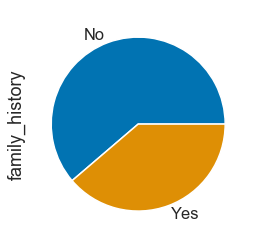

In [35]:
dfh= data.family_history.value_counts();
dfh.plot(kind='pie')

Have you sought treatment for a mental health condition?

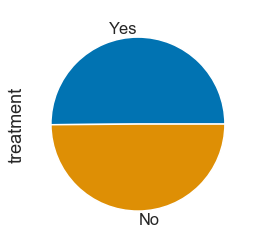

In [36]:
dt= data.treatment.value_counts();
dt.plot(kind='pie')

Next I will see what the average age is: 

Text(0.5, -0.05, 'Age')

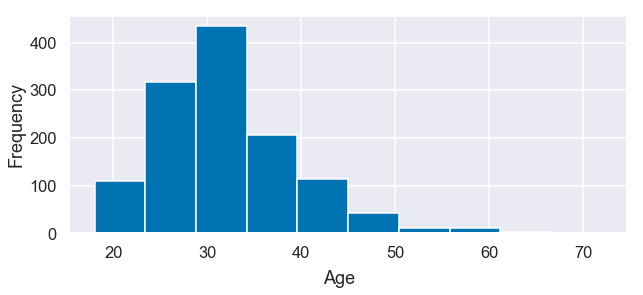

In [37]:
f, ax = plt.subplots(figsize=(10,4))
data.Age.plot(kind='hist')
plt.xticks(rotation=0, horizontalalignment='center')
f.text(0.5, -0.05, 'Age', ha='center')

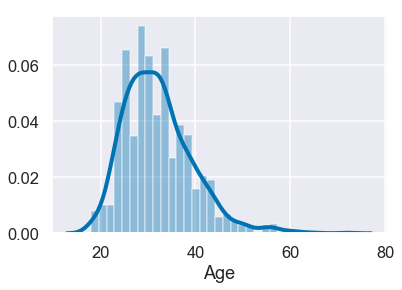

In [51]:
sns.distplot(data['Age'],hist=True, kde=True, 
             #bins=int(180/5), color = 'darkblue', 
             #hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

Now, I will see if there are any correlations between the variables in the dataset. First, with a range of the variables with the original survey data and then with the happiness data included. 

In [39]:
cor = data.corr()
cor;

In [40]:
df1=pd.DataFrame(data)
#demograhics 
df1['male'] = data['male'].astype('category').cat.codes
df1['female'] = data['female'].astype('category').cat.codes
df1['Country'] = data['Country'].astype('category').cat.codes
df1['state'] = data['state'].astype('category').cat.codes
#personal
df1['family_history'] = data['family_history'].astype('category').cat.codes
df1['treatment'] = data['treatment'].astype('category').cat.codes
#about the company
df1['care_options'] = data['care_options'].astype('category').cat.codes
df1['wellness_program'] = data['wellness_program'].astype('category').cat.codes
df1['seek_help'] = data['seek_help'].astype('category').cat.codes
df1['mental_health_consequence'] = data['mental_health_consequence'].astype('category').cat.codes
df1['phys_health_consequence'] = data['phys_health_consequence'].astype('category').cat.codes
df1['coworkers'] = data['coworkers'].astype('category').cat.codes
df1['supervisor'] = data['supervisor'].astype('category').cat.codes
df1['mental_vs_physical'] = data['mental_vs_physical'].astype('category').cat.codes
df1['obs_consequence'] = data['obs_consequence'].astype('category').cat.codes

Now, I will look at heat maps to see if there are any correlations with the variables. 

First, I will look if there are correlations in the original dataset. 
Next, I will look at the correlations in the merged dataset. 

Heat Map 1: Correlations in the original dataset variables

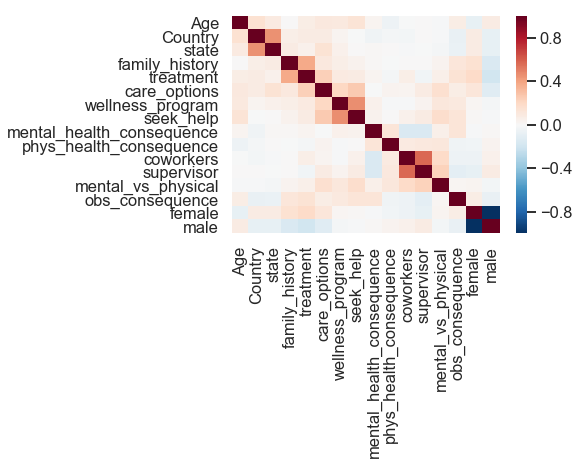

In [41]:
corr=df1.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap = 'RdBu_r')
#corr.style.background_gradient(cmap='RdBu_r', axis=1).set_precision(2)

Heat Map 2: Correlations between important variables in survey dataset and happiness dataset.

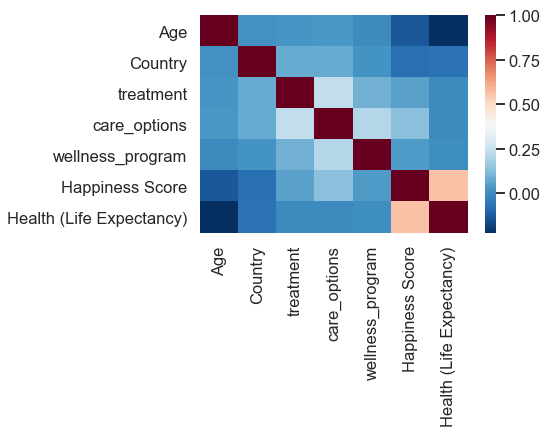

In [42]:
df2=pd.DataFrame(mergedata)
df2['Country'] = mergedata['Country'].astype('category').cat.codes
df2['Happiness Score'] = mergedata['Happiness Score'].astype('category').cat.codes
df2['care_options'] = mergedata['care_options'].astype('category').cat.codes
df2['wellness_program'] = mergedata['wellness_program'].astype('category').cat.codes
df2['treatment'] = mergedata['treatment'].astype('category').cat.codes

corr2=df2.corr()
sns.heatmap(corr2, 
        xticklabels=corr2.columns,
        yticklabels=corr2.columns, cmap = 'RdBu_r')

### 5. Machine Learning 

Now, I will attempt to perform a machine learning algorithm on my data through a random forest classifier. I will see if I can train variables to see if I can predict the happiness score from different variables from the survey. 

In [49]:
training_variables = ['treatment', 'care_options', 'Age', 'wellness_program']

X_train, X_test, y_train, y_test = train_test_split(mergedata[training_variables],
                 mergedata['Happiness Score'], test_size=0.2)

In [ ]:
#rf = RandomForestClassifier()
#param_dist = {"n_estimators": stats.randint(2, 300),
#              "max_features": ['sqrt',  'log2'],
#              "min_samples_split": stats.randint(5, 50),
#              "bootstrap": [True, False],
#              "criterion": ["gini", "entropy"]}
#random_rf = RandomizedSearchCV(rf, param_distributions=param_dist,
#                                   n_iter=20, cv=10, verbose=1, n_jobs=-1)
#random_rf.fit(X_train, y_train)

I could not figure out how to make the Random Forest to work to understand my data through Machine Learning. If I continue working on the data, I will try to understand this further. 

### 6. Results

Through the data interpretations I have done, there were not any correlations that I found in the variables. I am not sure if there is a mistake in my data cleaning process and this is why I found no correlations or if it is because there are truly any correlations in these variables. 

Since this is the core of my project goal, this inhibited me from doing any further analysis. 

Moreover, in terms of the Machine Learning component, it was difficult for me to utilize these methods with the nature of my dataset. There were not any variables that I would necessarily have to predict for, and the one that I tried out did not work out. 

Thanks for reading my report! :) 


**Sources**

[1] https://osmihelp.org/research  
[2] https://www.kaggle.com/lizpund/analysis-of-mental-health-in-tech-survey-2014  
[3] https://www.kaggle.com/diegocalvo/frequency-of-mental-health-illness-by-location  
[4] https://www.kaggle.com/kairosart/machine-learning-for-mental-health-1   
[5] https://www.kaggle.com/unsdsn/world-happiness
